In [19]:
import os
import glob
import numpy as np
import pandas as pd
import requests
import time

# for visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.graph_objects as go
import seaborn as sns


In [4]:
# Extract Raw data
PATH = os.path.expanduser("~/investor/data/raw")
all_files = glob.glob(os.path.join(PATH , "*.csv"))

all_df = []

for filename in all_files:
    file = pd.read_csv(filename, index_col=None, header=0)
    all_df.append(file)
    
df = pd.concat(all_df, axis=0, ignore_index=True)

# Renaming the columns by removing the '<' and '>' characters
new_column_names = {col: col.strip('<>').upper() for col in df.columns}
df = df.rename(columns=new_column_names)

# changing the integer dates to datetime format, taking 2002- NOW:
df = df[np.logical_and(df['DATE'] <= '2024-01-01', df['DATE'] > '2001-12-31')]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5537 entries, 0 to 5536
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    5537 non-null   object 
 1   OPEN    5537 non-null   float64
 2   HIGH    5537 non-null   float64
 3   LOW     5537 non-null   float64
 4   CLOSE   5537 non-null   float64
 5   VOLUME  5537 non-null   float64
dtypes: float64(5), object(1)
memory usage: 302.8+ KB


In [5]:
# OHLC prices: These are essential for technical analysis and commonly used to derive various technical indicators.
# Volume: Trading volume provides insights into market activity and liquidity.
# Calculate discrete returns
df['discrete_return'] = (df['CLOSE'] - df['CLOSE'].shift(1)) / df['CLOSE'].shift(1)
#df['discrete_return'] = np.log(df['OPEN']/df['OPEN'].shift(1)) # opposed to closing prices, to avoid look-ahead bias.

print(df.describe())
df.head()

              OPEN         HIGH          LOW        CLOSE        VOLUME  \
count  5537.000000  5537.000000  5537.000000  5537.000000  5.537000e+03   
mean   2032.993224  2044.721345  2020.494185  2033.362093  1.952158e+09   
std    1087.570787  1093.190057  1081.683342  1087.803827  7.841206e+08   
min     679.280000   695.270000   666.790000   676.530000  1.978167e+08   
25%    1191.380000  1198.620000  1184.490000  1191.500000  1.480139e+09   
50%    1525.100000  1532.400000  1518.750000  1525.400000  1.965294e+09   
75%    2712.400000  2728.090000  2696.880000  2711.450000  2.355871e+09   
max    4804.510000  4818.620000  4780.980000  4796.560000  6.364572e+09   

       discrete_return  
count      5536.000000  
mean          0.000331  
std           0.012224  
min          -0.119841  
25%          -0.004500  
50%           0.000669  
75%           0.005813  
max           0.115800  


,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,discrete_return
0,2002-01-02,1148.08,1154.67,1136.23,1154.67,650555556.0,NaN
1,2002-01-03,1154.67,1165.27,1154.01,1165.27,777166667.0,0.009180
2,2002-01-04,1165.27,1176.55,1163.42,1172.51,840555556.0,0.006213
3,2002-01-07,1172.51,1176.97,1163.55,1164.89,726833333.0,-0.006499
4,2002-01-08,1164.89,1167.60,1157.46,1160.71,699333333.0,-0.003588


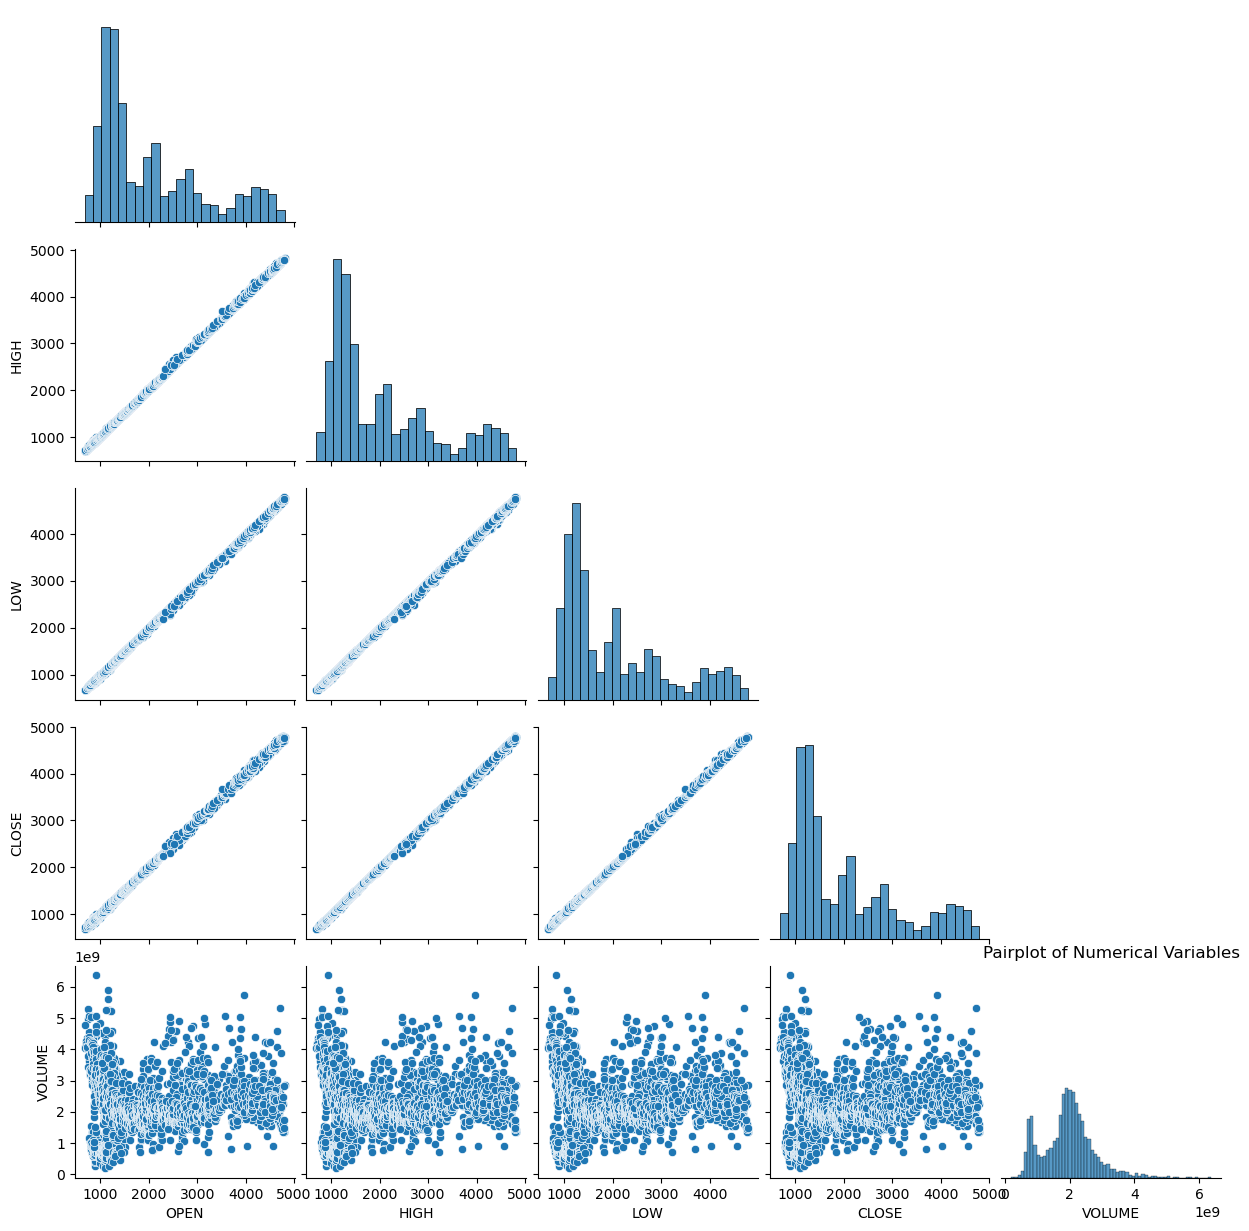

In [6]:
# Pairplot to visualize relationships between numerical variables
sns.pairplot(df[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME']], corner=True)
plt.title('Pairplot of Numerical Variables')
plt.show()

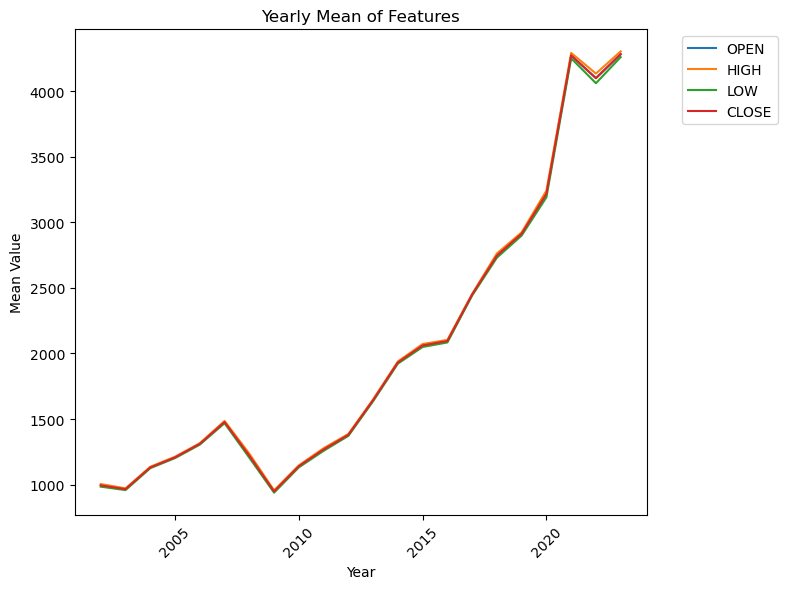

In [7]:
df_A = df.copy()
df_A['DATE'] = pd.to_datetime(df_A['DATE'])

# Extract year from the 'DATE' column
df_A['Year'] = df_A['DATE'].dt.year

# Aggregate data by year and compute the mean for each feature
yearly_data = df_A[['Year','OPEN', 'HIGH', 'LOW', 'CLOSE']].groupby('Year').mean()

# Reset index to have 'Year' as a regular column
yearly_data.reset_index(inplace=True)

# Melt the DataFrame to have a single x-axis for all features
melted_yearly_data = yearly_data.melt(id_vars=['Year'], var_name='Feature', value_name='Mean Value')

# Create a line plot
plt.figure(figsize=(8, 6))
sns.lineplot(data=melted_yearly_data, x='Year', y='Mean Value', hue='Feature')
plt.title('Yearly Mean of Features')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

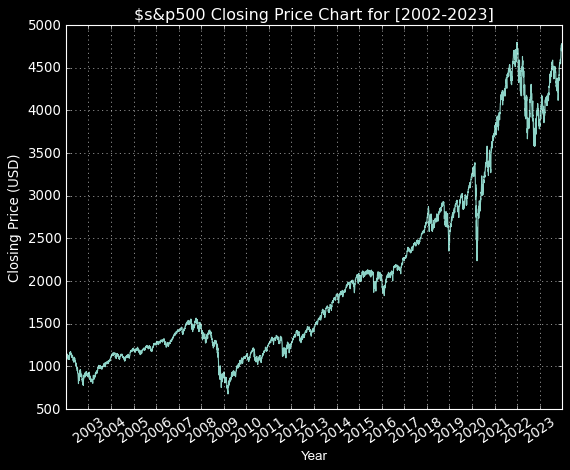

In [21]:
# create the font object
font = fm.FontProperties(family='Arial', size=12)

# Assign ticker symbol and data interval
symbol = 's&p500'
startDate = '2001-12-31'
endDate = '2024-01-01'

# Convert 'date' column to datetime if it's not already in datetime format
df_plot = df.copy()
df_plot = df_plot[np.logical_and(df_plot['DATE'] <= endDate, df_plot['DATE'] > startDate)]
df_plot['DATE'] = pd.to_datetime(df_plot['DATE'])
#years = df_plot['DATE'].dt.year  # Extract years from the 'date' column
#years_ticks = np.arange(years.iloc[0], years.iloc[-1] + 1 ) #just the unique year numbers
#years_ticks = np.unique(years)


# Plotting closing price of the stock with respect to time
plt.style.use('classic')
plt.style.use('dark_background')
plt.plot(df_plot['DATE'], df_plot['CLOSE'])  


# Set x-axis tick format to display only years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y"))

# Adjust tick frequency if needed
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# plt.plot(data['Close'],'-o')  # For marking every datapoint 
plt.xlabel('Year', fontproperties=font)
plt.ylabel('Closing Price (USD)')
plt.title(f'${symbol} Closing Price Chart for [2002-2023]')
plt.xticks(rotation=35)  # For readability of time labels in x-axis (rotated by 35 degrees)
plt.grid(True,linestyle='dotted',)  # False for closing grids
#plt.savefig("figs/closingPrice_"+str(symbol)+str(startDate)+str(endDate)+".png")  # Save plot as indicated directory with name specified
plt.show()

In [14]:
#Simple Moving Avarage 
window_size = 15
#SMA Signal = Pt(current price as close price) - SMA
SMA =  df['CLOSE'].rolling(window=window_size).mean()
SMA_signal = df['CLOSE'] - SMA

In [25]:
#Simple Moving Average over 50 days
SMA_50 = df['CLOSE'].rolling(window=50).mean()
#Simple Moving Average over 200 days
SMA_200 = df['CLOSE'].rolling(window=200).mean()

# death cross occurs when the 50-day SMA crosses below the 200-day SMA. This is considered a bearish signal, indicating that further losses are in store. 
# The golden cross occurs when a short-term SMA breaks above a long-term SMA. Reinforced by high trading volumes, this can signal further gains are in store.

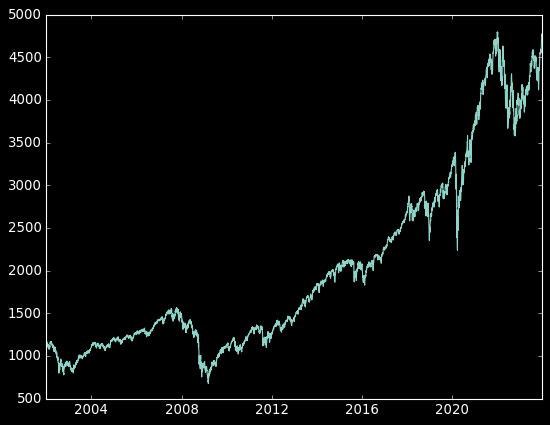

In [29]:

# Plotting closing price of the stock with respect to time
plt.style.use('classic')
plt.style.use('dark_background')
plt.plot(df_plot['DATE'], df_plot['CLOSE'])  

# Create traces for each plot
trace_close = go.Scatter(x=df_plot['DATE'], y=df_plot['CLOSE'], mode='lines', name='Closing Price')
trace_sma = go.Scatter(x=df_plot['DATE'], y=SMA, mode='lines', name='SMA_15')
trace_sma_50 = go.Scatter(x=df_plot['DATE'], y=SMA_50, mode='lines', name='SMA_50')
trace_sma_200= go.Scatter(x=df_plot['DATE'], y=SMA_200, mode='lines', name='SMA_200')

# Create layout
layout = go.Layout(
    title='Closing Price and Volume',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Value in USD'),
    hovermode='x'  # Show closest data point on hover
)

# Create figure and add traces
fig = go.Figure(data=[trace_close, trace_sma, trace_sma_50, trace_sma_200], layout=layout)

# Show interactive plot
fig.show()

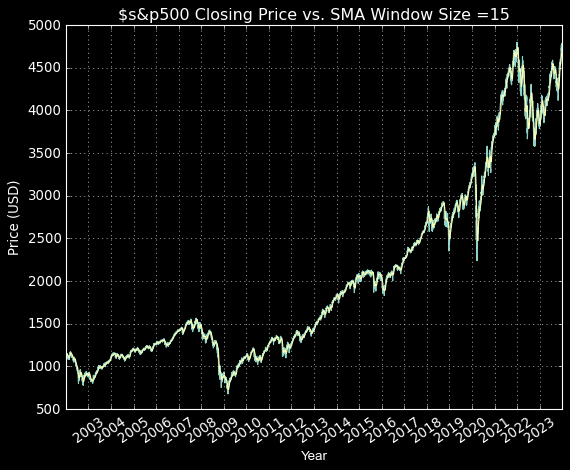

In [16]:

# Plotting closing price of the stock with respect to time
plt.style.use('classic')
plt.style.use('dark_background')
plt.plot(df_plot['DATE'], df_plot['CLOSE'], label='Closing Price')  
plt.plot(df_plot['DATE'], SMA, label='SMA')  


# Set x-axis tick format to display only years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y"))

# Adjust tick frequency if needed
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# plt.plot(data['Close'],'-o')  # For marking every datapoint 
plt.xlabel('Year', fontproperties=font)
plt.ylabel('Price (USD)')
plt.title(f'${symbol} Closing Price vs. SMA Window Size =15')
plt.xticks(rotation=35)  # For readability of time labels in x-axis (rotated by 35 degrees)
plt.grid(True,linestyle='dotted',)  # False for closing grids
#plt.savefig("figs/closingPrice_"+str(symbol)+str(startDate)+str(endDate)+".png")  # Save plot as indicated directory with name specified
plt.show()

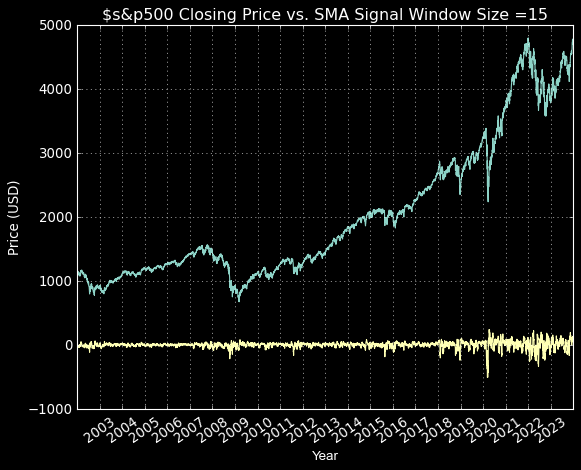

In [17]:
# Plotting closing price of the stock with respect to time
plt.style.use('classic')
plt.style.use('dark_background')
plt.plot(df_plot['DATE'], df_plot['CLOSE'], label='Closing Price')  
plt.plot(df_plot['DATE'], SMA_signal, label='SMA Signal')  


# Set x-axis tick format to display only years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y"))

# Adjust tick frequency if needed
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# plt.plot(data['Close'],'-o')  # For marking every datapoint 
plt.xlabel('Year', fontproperties=font)
plt.ylabel('Price (USD)')
plt.title(f'${symbol} Closing Price vs. SMA Signal Window Size =15')
plt.xticks(rotation=35)  # For readability of time labels in x-axis (rotated by 35 degrees)
plt.grid(True,linestyle='dotted',)  # False for closing grids
#plt.savefig("figs/closingPrice_"+str(symbol)+str(startDate)+str(endDate)+".png")  # Save plot as indicated directory with name specified
plt.show()

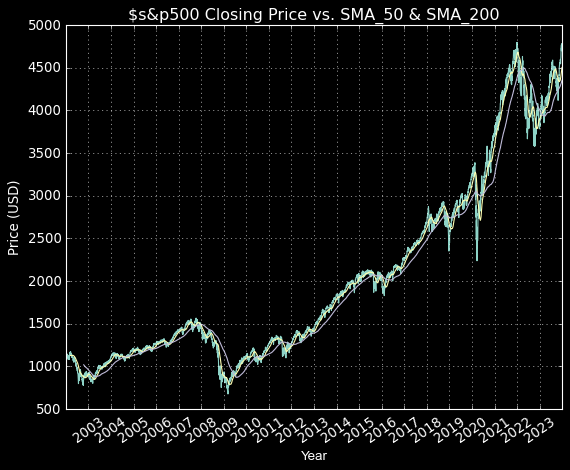

In [18]:


# Plotting closing price of the stock with respect to time
plt.style.use('classic')
plt.style.use('dark_background')
plt.plot(df_plot['DATE'], df_plot['CLOSE'], label='Closing Price')  
plt.plot(df_plot['DATE'], SMA_50, label='SMA Signal')  
plt.plot(df_plot['DATE'], SMA_200, label='SMA Signal')  

# Set x-axis tick format to display only years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y"))

# Adjust tick frequency if needed
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# plt.plot(data['Close'],'-o')  # For marking every datapoint 
plt.xlabel('Year', fontproperties=font)
plt.ylabel('Price (USD)')
plt.title(f'${symbol} Closing Price vs. SMA_50 & SMA_200')
plt.xticks(rotation=35)  # For readability of time labels in x-axis (rotated by 35 degrees)
plt.grid(True,linestyle='dotted',)  # False for closing grids
#plt.savefig("figs/closingPrice_"+str(symbol)+str(startDate)+str(endDate)+".png")  # Save plot as indicated directory with name specified
plt.show()

In [38]:
#Weighted Moving Average
def calculate_wma(data, window):
    weights = np.arange(1, window + 1)
    wma = data.rolling(window=window).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return wma

In [39]:

# Define the window size for WMA calculation
window_size = 15

# Calculate WMA with the specified window size
WMA = calculate_wma(df['CLOSE'], window_size)

WMA_signal = df['CLOSE'] - WMA

In [40]:

# Define the window size for EMA calculation
window_size = 15

# Calculate EMA with the specified window size
#α = 2 / (N + 1)
EMA = df['CLOSE'].ewm(span=window_size).mean()

EMA_signal = df['CLOSE'] - EMA

In [41]:
#Moving Average Convergence Divergence (MACD)
# Define periods for short-term and long-term EMAs
short_period = 12
long_period = 26
signal_line_span = 9

# Calculate short-term EMA
short_ema = df['CLOSE'].ewm(span=short_period, adjust=False).mean()

# Calculate long-term EMA
long_ema = df['CLOSE'].ewm(span=long_period, adjust=False).mean()

# Calculate MACD line
macd_line = short_ema - long_ema

# Calculate Signal line (typically 9-period EMA of MACD line)
signal_line = macd_line.ewm(span=signal_line_span, adjust=False).mean()

# Calculate MACD signal
macd_signal = macd_line - signal_line

In [42]:
# Define periods for calculating highest high and lowest low
window_size = 14

# Calculate highest high and lowest low over the period
HH = df['HIGH'].rolling(window=window_size).max()
LL = df['LOW'].rolling(window=window_size).min()

# Calculate %K line for Fast Stochastic Oscillator
K_Fast = 100 * ((df['CLOSE'] - LL) / (HH - LL))

# Calculate %D line for Fast Stochastic Oscillator (typically a 3-period SMA of %K)
period_d_fast = 3
D_Fast = K_Fast.rolling(window=period_d_fast).mean()

# Calculate %K line for Slow Stochastic Oscillator
# This is not a feture as suggested by the article 
period_slow = 3
K_Slow = K_Fast.rolling(window=period_slow).mean()

# Calculate %D line for Slow Stochastic Oscillator (typically a 3-period SMA of %K_Slow)
period_d_slow = 3
D_Slow = K_Slow.rolling(window=period_d_slow).mean()

In [43]:
#Need to validate this code 
#Relative Strength Index (RSI)
window_size = 14

# Calculate price changes
Price_Change = df['CLOSE'].diff()

# Calculate gains and losses
Gain = np.where(Price_Change > 0, Price_Change, 0)
Loss = np.where(Price_Change < 0, abs(Price_Change), 0)

# Calculate average gain and average loss over the period
Avg_Gain = pd.Series(Gain).rolling(window=window_size, min_periods=1).mean()
Avg_Loss = pd.Series(Loss).rolling(window=window_size, min_periods=1).mean()

# Calculate Relative Strength (RS)
RS = Avg_Gain / Avg_Loss

# Calculate RSI
RSI = 100 - (100 / (1 + RS))

In [44]:
rsi_values = []
window_size = 14
for i in range(window_size, len(df['CLOSE'])):
    gains = [df['CLOSE'][j - 1] - df['CLOSE'][j] for j in range(i - (window_size - 1), i) if df['CLOSE'][j - 1] > df['CLOSE'][j]]
    losses = [-1 * (df['CLOSE'][j - 1] - df['CLOSE'][j]) for j in range(i - (window_size - 1), i) if df['CLOSE'][j - 1] < df['CLOSE'][j]]

    avg_gain = sum(gains) / window_size if gains else 0
    avg_loss = sum(losses) / window_size if losses else 0

    if avg_loss == 0:
        rsi = 100
    else:
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
    
    rsi_values.append(rsi)

In [45]:
# Define period for WPR calculation
window_size = 14

# Calculate highest high and lowest low over the period
Highest_High = df['HIGH'].rolling(window=window_size).max()
Lowest_Low = df['LOW'].rolling(window=window_size).min()

# Calculate Williams %R
WPR = (Highest_High - df['CLOSE']) / (Highest_High - Lowest_Low) * -100


In [46]:
type(WPR)

pandas.core.series.Series